In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as tm

# Input Data

In [2]:
# Importing the Data related to the Environmental Conditions
data = pd.read_excel("D:\PHD-RESEARCH\Results\Timber Moisture Transport\Script (Python)\RELATIVEHUMIDITY1.xlsx",sheet_name="Sheet1",index_col=None,header=0).to_numpy()
# Total Number of Rows from the Imported Data
Nrow = len(data)
# Time 
TimeD = np.zeros((Nrow,1)) # (day)
for i in range(0,Nrow):
    TimeD[i] = data[i,0]
# Environmental Temperature
TempC = np.zeros((Nrow,1)) # (degrees Celsius)
for i in range(0,Nrow):
    TempC[i] = data[i,1]
# Environmental Relative Humidity
RHum = np.zeros((Nrow,1)) # (percentage)
for i in range(0,Nrow):
    RHum[i] = data[i,2]
# Equilibrium Moisture Content
UHum = np.zeros((Nrow,1)) # (percentage)
for i in range(0,Nrow):
    UHum[i] = data[i,3]
# Time Step
DT = max(TimeD)/(len(TimeD)-1) # day
# Geometry of the Section
H = 8.9 # Height (cm)
W = 8.9 # Width  (cm)
# Initial Moisture Content
Moisture_0 = 0.108282179
# Discretization of the Section
nx = 24
ny = 24

# Input Local Functions

In [3]:
# Diffusion coefficient in x-direction 
def Diffx(Moisture):
    Coefficient_x = 0.10368*(np.exp(2.28*Moisture)) # (cm^2/day) 
    return Coefficient_x

In [4]:
# Diffusion coefficient in y-direction 
def Diffy(Moisture):
    Coefficient_y = 0.10368*(np.exp(2.28*Moisture)) # (cm^2/day) 
    return Coefficient_y

In [5]:
# Surface Emissivity at the Right-Hand Side Boundary
def Sxr(Moisture):
    Coefficient_xr = 1.1232 # (cm/day) 
    return Coefficient_xr

In [6]:
# Surface Emissivity at the Left-Hand Side Boundary 
def Sxl(Moisture):
    Coefficient_xl = 1.1232 # (cm/day) 
    return Coefficient_xl

In [7]:
# Surface Emissivity at the Top Boundary
def Syt(Moisture):
    Coefficient_yt = 1.1232 # (cm/day) 
    return Coefficient_yt

In [8]:
# Surface Emissivity at the Bottom Boundary
def Syb(Moisture):
    Coefficient_yb = 1.1232 # (cm/day) 
    return Coefficient_yb

# Set Local Functions

In [9]:
def Mesh(Width,number_x,Height,number_y):
    Matrix_XY = np.zeros((10000,4))
    Matrix_XX = np.zeros((10000,8))
    Matrix_YY = np.zeros((10000,8)) 
    X0 = 0.0
    Y0 = 0.0
    ni = int(number_x+1)
    nj = int(number_y+1)
    dx = Width/number_x
    dy = Height/number_y
    k = -1
    for i in range(0,ni):
        for j in range(0,nj):
            k = k+1
            Matrix_XY[k,:] = np.array([X0+dx*(i),Y0+dy*(j),i+1,j+1])
    Matrix_XY = Matrix_XY[0:k+1,:]
    number_nodes = k+1
    k = -1
    for i in range(0,ni-1):
        for j in range(0,nj-1):
            k = k+1
            X1 = X0+dx*(i)
            X2 = X1+dx
            X3 = X2
            X4 = X1
            Y1 = Y0+dy*(j)
            Y2 = Y1
            Y3 = Y1+dy
            Y4 = Y3
            Matrix_XX[k,:] = np.array([X1,X2,X3,X4,i+1,i+2,i+2,i+1])
            Matrix_YY[k,:] = np.array([Y1,Y2,Y3,Y4,j+1,j+1,j+2,j+2])
    Matrix_XX = Matrix_XX[0:k+1,:]
    Matrix_YY = Matrix_YY[0:k+1,:]
    number_elements = k+1
    return number_nodes, number_elements, Matrix_XY, Matrix_XX, Matrix_YY

In [10]:
def Pos_Index(coordinate_i,coordinate_j,Matrix_XY,number_nodes):
    for k in range(0,number_nodes):
        if Matrix_XY[k,2] == coordinate_i and Matrix_XY[k,3] == coordinate_j:
            break
    return k

In [11]:
def Pos_Matrix(Matrix_XY,number_nodes):
    Matrix_Pos = np.zeros((number_nodes,5))
    for k in range(0,number_nodes):
        x = Matrix_XY[k,0]
        y = Matrix_XY[k,1]
        i = Matrix_XY[k,2]
        j = Matrix_XY[k,3]
        if x == W and 0 < y < H:
            Matrix_Pos[k,0] = 0
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        elif x == 0 and 0 < y < H:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = 0
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)      
        elif y == H and 0 < x < W:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = 0
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)    
        elif y == 0 and 0 < x < W:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = 0
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)                 
        elif x == W and y == H:
            Matrix_Pos[k,0] = 0
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = 0
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)              
        elif x == W and y == 0:
            Matrix_Pos[k,0] = 0
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = 0
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes) 
        elif x == 0 and y == H:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = 0
            Matrix_Pos[k,2] = 0
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)   
        elif x == 0 and y == 0:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = 0
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = 0
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
        else:
            Matrix_Pos[k,0] = Pos_Index(i+1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,1] = Pos_Index(i-1,j,Matrix_XY,number_nodes)
            Matrix_Pos[k,2] = Pos_Index(i,j+1,Matrix_XY,number_nodes)
            Matrix_Pos[k,3] = Pos_Index(i,j-1,Matrix_XY,number_nodes)
            Matrix_Pos[k,4] = Pos_Index(i,j,Matrix_XY,number_nodes)
    return Matrix_Pos

In [12]:
def ColorMatrix(number_points):
    Matrix_Color=np.zeros((number_points,3))
    for i in range(0,number_points):
        if i == 0:
            Matrix_Color[0,:]=[0.0,0.0,0.0]
        elif i == 1:
            Matrix_Color[1,:]=[1.0,0.0,0.0]
        elif i == 2:
            Matrix_Color[2,:]=[0.0,1.0,0.0]
        elif i == 3:
            Matrix_Color[3,:]=[0.0,0.0,1.0]
        elif i == 4:
            Matrix_Color[4,:]=[0.0,1.0,1.0]
        elif i == 5:
            Matrix_Color[5,:]=[1.0,0.0,1.0]
        elif i == 6:
            Matrix_Color[6,:]=[1.0,1.0,0.0]
        else:
            Matrix_Color[i,:]=np.random.rand(3)
    return Matrix_Color

In [13]:
def LabelList(listnodes):
    number_selected_nodes=len(listnodes)
    for i in range(0,number_selected_nodes+1):
        if i == 0:
            Matrix_Label=['Average']
        else:
            Matrix_Label.append('Node'+str(listnodes[i-1]))
    return Matrix_Label 

# Finite Difference Method

In [14]:
start = tm.time()

In [15]:
dx = W/nx
dy = H/ny

In [16]:
npt, nel, XY, XX, YY = Mesh(W,nx,H,ny)

In [17]:
PM = Pos_Matrix(XY,npt)

In [18]:
UT = np.zeros((npt,Nrow),dtype='float')
UT0 = np.zeros(npt,dtype='float')
UT1 = np.zeros(npt,dtype='float')

In [19]:
for t in range(0,Nrow-1):
    if t == 0:
        for i in range(0,npt):
            UT[i,t] = Moisture_0
    UT0 = UT[:,t]
    A = np.zeros((npt,npt),dtype='float')
    B = np.zeros(npt,dtype='float')
    for k in range(0,npt):
        x = XY[k,0]
        y = XY[k,1]
        a = np.zeros(npt,dtype='float')
        P1 = int(PM[k,0])
        P2 = int(PM[k,1])
        P3 = int(PM[k,2])
        P4 = int(PM[k,3])
        P5 = int(PM[k,4])     
        if x == W and 0 < y < H:
            C2 = (Diffx(UT[P5,t])+Diffx(UT[P2,t]))/2
            C3 = (Diffy(UT[P5,t])+Diffy(UT[P3,t]))/2
            C4 = (Diffy(UT[P5,t])+Diffy(UT[P4,t]))/2
            a[P2] = 2*DT*C2/dx**2
            a[P3] = DT*C3/dy**2
            a[P4] = DT*C4/dy**2
            a[P5] = 1-2*DT*C2/dx**2-DT*C3/dy**2-DT*C4/dy**2-2*DT*Sxr(UT[P5,t])/dx
            constant = 2*DT*Sxr(UT[P5,t])/dx*UHum[t]
        elif x == 0 and 0 < y < H:
            C1 = (Diffx(UT[P5,t])+Diffx(UT[P1,t]))/2
            C3 = (Diffy(UT[P5,t])+Diffy(UT[P3,t]))/2
            C4 = (Diffy(UT[P5,t])+Diffy(UT[P4,t]))/2
            a[P1] = 2*DT*C1/dx**2
            a[P3] = DT*C3/dy**2
            a[P4] = DT*C4/dy**2
            a[P5] = 1-2*DT*C1/dx**2-DT*C3/dy**2-DT*C4/dy**2-2*DT*Sxl(UT[P5,t])/dx
            constant = 2*DT*Sxl(UT[P5,t])/dx*UHum[t]        
        elif y == H and 0 < x < W:
            C1 = (Diffx(UT[P5,t])+Diffx(UT[P1,t]))/2
            C2 = (Diffx(UT[P5,t])+Diffx(UT[P2,t]))/2
            C4 = (Diffy(UT[P5,t])+Diffy(UT[P4,t]))/2
            a[P1] = DT*C1/dx**2
            a[P2] = DT*C2/dx**2
            a[P4] = 2*DT*C4/dy**2
            a[P5] = 1-DT*C1/dx**2-DT*C2/dx**2-2*DT*C4/dy**2-2*DT*Syt(UT[P5,t])/dy
            constant = 2*DT*Syt(UT[P5,t])/dy*UHum[t]        
        elif y == 0 and 0 < x < W:
            C1 = (Diffx(UT[P5,t])+Diffx(UT[P1,t]))/2
            C2 = (Diffx(UT[P5,t])+Diffx(UT[P2,t]))/2
            C3 = (Diffy(UT[P5,t])+Diffy(UT[P3,t]))/2
            a[P1] = DT*C1/dx**2
            a[P2] = DT*C2/dx**2
            a[P3] = 2*DT*C3/dy**2
            a[P5] = 1-DT*C1/dx**2-DT*C2/dx**2-2*DT*C3/dy**2-2*DT*Syb(UT[P5,t])/dy
            constant = 2*DT*Syb(UT[P5,t])/dy*UHum[t]                
        elif x == W and y == H:
            C2 = (Diffx(UT[P5,t])+Diffx(UT[P2,t]))/2
            C4 = (Diffy(UT[P5,t])+Diffy(UT[P4,t]))/2
            a[P2] = 2*DT*C2/dx**2
            a[P4] = 2*DT*C4/dy**2
            a[P5] = 1-2*DT*C2/dx**2-2*DT*C4/dy**2-2*DT*Sxr(UT[P5,t])/dx-2*DT*Syt(UT[P5,t])/dy
            constant = (2*DT*Sxr(UT[P5,t])/dx+2*DT*Syt(UT[P5,t])/dy)*UHum[t]               
        elif x == W and y == 0:
            C2 = (Diffx(UT[P5,t])+Diffx(UT[P2,t]))/2
            C3 = (Diffy(UT[P5,t])+Diffy(UT[P3,t]))/2
            a[P2] = 2*DT*C2/dx**2
            a[P3] = 2*DT*C3/dy**2
            a[P5] = 1-2*DT*C2/dx**2-2*DT*C3/dy**2-2*DT*Sxr(UT[P5,t])/dx-2*DT*Syb(UT[P5,t])/dy
            constant = (2*DT*Sxr(UT[P5,t])/dx+2*DT*Syb(UT[P5,t])/dy)*UHum[t]  
        elif x == 0 and y == H:
            C1 = (Diffx(UT[P5,t])+Diffx(UT[P1,t]))/2
            C4 = (Diffy(UT[P5,t])+Diffy(UT[P4,t]))/2
            a[P1] = 2*DT*C1/dx**2
            a[P4] = 2*DT*C4/dy**2
            a[P5] = 1-2*DT*C1/dx**2-2*DT*C4/dy**2-2*DT*Sxl(UT[P5,t])/dx-2*DT*Syt(UT[P5,t])/dy
            constant = (2*DT*Sxl(UT[P5,t])/dx+2*DT*Syt(UT[P5,t])/dy)*UHum[t]  
        elif x == 0 and y == 0:
            C1 = (Diffx(UT[P5,t])+Diffx(UT[P1,t]))/2
            C3 = (Diffy(UT[P5,t])+Diffy(UT[P3,t]))/2
            a[P1] = 2*DT*C1/dx**2
            a[P3] = 2*DT*C3/dy**2
            a[P5] = 1-2*DT*C1/dx**2-2*DT*C3/dy**2-2*DT*Sxl(UT[P5,t])/dx-2*DT*Syb(UT[P5,t])/dy
            constant = (2*DT*Sxl(UT[P5,t])/dx+2*DT*Syb(UT[P5,t])/dy)*UHum[t]   
        else:
            C1 = (Diffx(UT[P5,t])+Diffx(UT[P1,t]))/2
            C2 = (Diffx(UT[P5,t])+Diffx(UT[P2,t]))/2
            C3 = (Diffy(UT[P5,t])+Diffy(UT[P3,t]))/2
            C4 = (Diffy(UT[P5,t])+Diffy(UT[P4,t]))/2
            a[P1] = DT*C1/dx**2
            a[P2] = DT*C2/dx**2
            a[P3] = DT*C3/dy**2
            a[P4] = DT*C4/dy**2
            a[P5] = 1-DT*C1/dx**2-DT*C2/dx**2-DT*C3/dy**2-DT*C4/dy**2
            constant = 0
        
        A[k,:] = a
        B[k] = constant
    
    UT1 = np.matmul(A,UT0)+B
    amplification = np.amax(np.absolute((UT1-UT0)/UT0))
    if amplification > 10:
        raise ValueError("The Numerical Stability is compromised")
    UT[:,t+1] = UT1

In [20]:
end = tm.time()

In [21]:
Compution_time = end-start

In [22]:
print(Compution_time)

30.97895359992981


# Output Data

In [23]:
TimeH = np.zeros((Nrow,1))
for i in range(0,Nrow):
    TimeH[i] = TimeD[i]*24

In [24]:
Timemax=np.amax(TimeH)
Timemin=np.amin(TimeH)
TCmax=np.amax(TempC)
TCmin=np.amin(TempC)
RHmax=np.amax(RHum)
RHmin=np.amin(RHum)
UTmax=np.amax(UT)
UTmin=np.amin(UT)

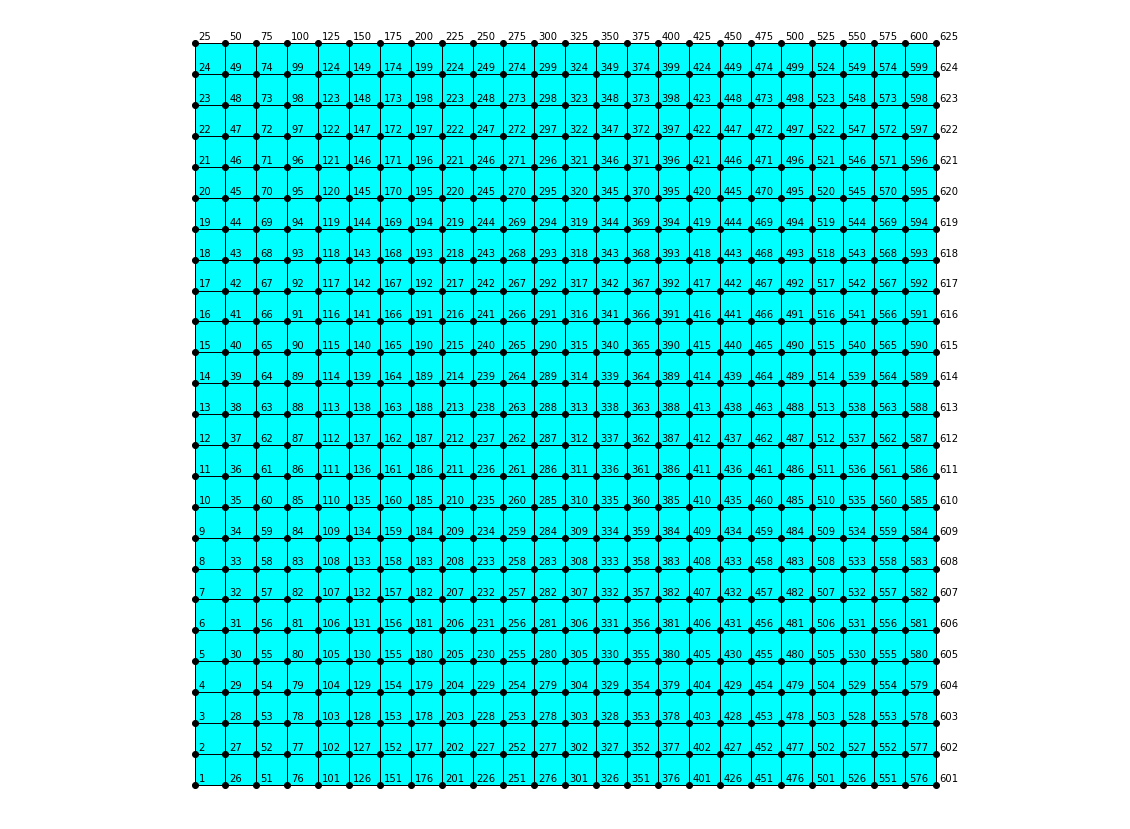

In [25]:
plt.figure(1,figsize=(20.0,15.0))
for k in range(0,nel):
    plt.fill(XX[k,0:4],YY[k,0:4],facecolor=(0.0,1.0,1.0),edgecolor='black')
for k in range(0,npt):
    plt.plot(XY[k,0],XY[k,1],marker='o',color='black')
    plt.text(XY[k,0]+dx/8,XY[k,1]+dy/8,str(k+1),fontsize=10)
plt.axis('equal')
plt.axis('off')
plt.show()

In [26]:
UTaverage = np.zeros((Nrow,1))
for t in range(0,Nrow):
    UTaverage[t] = sum(UT[:,t])/npt

In [27]:
nnodes = int(input("Enter the total number of nodes: "))
lnodes = np.array([],int)
for i in range(nnodes):
    lnodes = np.append(lnodes,int(input("Enter the number label of the node: ")))

Enter the total number of nodes: 0


In [28]:
MMC = np.zeros((Nrow,nnodes+1))
for t in range(0,Nrow):
    MMC[t,0] = UTaverage[t]
for i in range(0,nnodes):
    for t in range(0,Nrow):
        MMC[t,i+1] = UT[lnodes[i]-1,t]

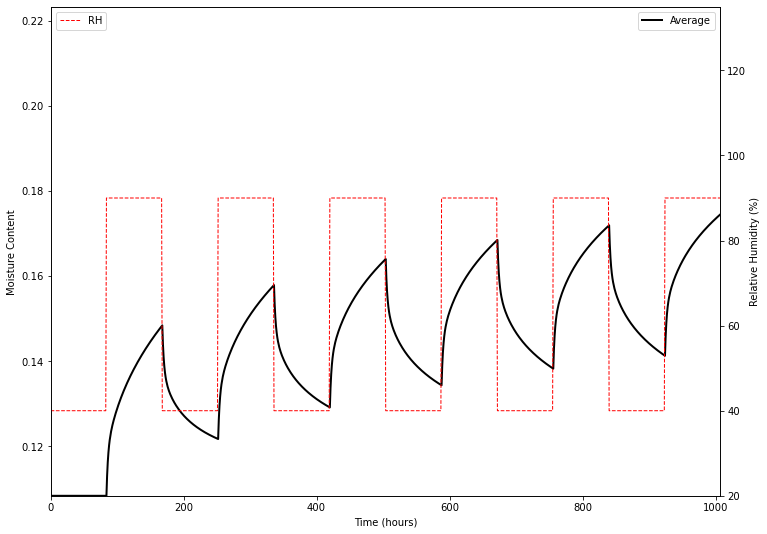

In [29]:
fig,ax1 = plt.subplots(figsize=(12.0,9.0))
ax2 = ax1.twinx()
ColorIndex=ColorMatrix(nnodes+1)            
LabelIndex=LabelList(lnodes)
for i in range(0,nnodes+1):
    ax1.plot(TimeH,MMC[:,i],color=ColorIndex[i,:],linestyle='solid',linewidth=2,label=LabelIndex[i])
ax2.plot(TimeH,RHum,color='r',linestyle='dashed',linewidth=1,label='RH')
ax1.set_xlabel('Time (hours)')
ax1.set_xlim(Timemin,Timemax)
ax1.set_ylabel('Moisture Content',color='k')
ax1.set_ylim(UTmin,UTmax)
ax2.set_ylabel('Relative Humidity (%)',color='k')
ax2.set_ylim(0.5*RHmin,1.5*RHmax)
# ax2.set_ylabel('Temperature (°C)',color='k')
# ax2.set_ylim(0.5*TCmin,1.5*TCmax)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

# Writing Output Data to a File

In [30]:
listallnodes = np.arange(1,npt+1,1)
LabelAllIndex = LabelList(listallnodes)
MMCAll = np.zeros((Nrow,npt+1))
for t in range(0,Nrow):
    MMCAll[t,0] = UTaverage[t]
for i in range(0,npt):
    for t in range(0,Nrow):
        MMCAll[t,i+1] = UT[listallnodes[i]-1,t]

In [31]:
OUT1 = 'Time'
OUT2 = LabelAllIndex
OUT3 = np.append(OUT1,OUT2)
OUT4 = TimeH
OUT5 = MMCAll
OUT6 = np.column_stack((OUT4,OUT5))
result1 = pd.DataFrame([OUT3])
result2 = pd.DataFrame(OUT6)
result = result1.append(result2)
writer = pd.ExcelWriter('Square_Explicit_Results.xlsx',engine='xlsxwriter')
result.to_excel(writer,sheet_name='Moisture_Content_Matrix',index=False,header=False)
writer.save()